## Testing the fastmap classifying algorithm
FastMapSVM is an interpretable machine learning framework for classifying complex objects, combining the complementary strengths of FastMap with support vector machines (SVMs). Fastmap projects the solution into a lower-dimensional space which can be used for clustering and anomaly detection.

Code: https://github.com/malcolmw/FastMapSVM
Paper: https://doi.org/10.1038/s44172-023-00099-8

In [13]:
%matplotlib notebook
import pandas as pd
import numpy as np
import os
import obspy
from obspy.core.utcdatetime import UTCDateTime
import matplotlib.pyplot as plt
import h5py
import seaborn as sns 

import fastmap
import sklearn
from sklearn.pipeline import Pipeline

In [2]:
def correlate(a, b, axis=-1):
    A = np.fft.rfft(a, axis=axis)
    B = np.fft.rfft(b, axis=axis)
    X = A * np.conj(B)
    x = np.fft.irfft(X)
    x = np.fft.fftshift(x, axes=axis)
    norm = np.sqrt(
        a.shape[-1] * np.var(a, axis=axis)
        *
        b.shape[-1] * np.var(b, axis=axis)
    )
    norm = norm[..., np.newaxis]

    return np.nan_to_num(x / norm, neginf=0, posinf=0)

def correlation_distance(a, b, axis=-1):
    '''
    Compute the pair-wise correlation distance matrix.
    '''
    xcorr = correlate(a, b, axis=axis)
    xcorr = np.abs(xcorr)
    xcorr = np.nanmean(xcorr, axis=-2)
    xcorr = np.max(xcorr, axis=-1)
    xcorr = np.clip(xcorr, 0, 1)

    return 1 - xcorr

class FastMap(fastmap.FastMapABC):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._distance_func = correlation_distance

In [44]:
from math import log, ceil, floor
def closest_power(x, power=8):
    possible_results = floor(log(x, power)), ceil(log(x, power))
    return min(possible_results, key= lambda z: abs(x-power**z))

def load_data(root_dir, h5_file, normalize=True, constrain_size=True, masking_factor=0.25):
    filepath = f'{root_dir}{h5_file}'
    event_types = ''
    with h5py.File(filepath, "r") as f:
        X = f['X'][:]
        labels = f['label'][:]
        windows = f['window'][:]
        ids = f['id'][:]
       
    if constrain_size:
        power = closest_power(X.shape[1], power=2)
        max_size = 2**power
        if max_size > X.shape[1]:
            power -= 1
            max_size = 2**power
        print(max_size, power, X.shape)
        X = X[:,:max_size,:]
        labels = labels[:,:max_size,:]
    
    normalize_type = 'std'
    if normalize:
        
        if normalize_type == 'std':
            mean = np.expand_dims(np.mean(labels[:,:,0], axis=1), axis=1)
            std = np.expand_dims(np.std(labels[:,:,0], axis=1), axis=1)
            X[:,:,0] = (X[:,:,0]-mean)/std
            #min_per_entry = abs(np.expand_dims(np.min(X[:,:,0], axis=1), axis=1))
            #X[:,:,0] = X[:,:,0]+min_per_entry
            labels[:,:,0] = X[:,:,0]
        else:
            min_per_entry = np.expand_dims(np.min(labels[:,:,0], axis=1), axis=1)
            #print('min_per_entry', min_per_entry.shape)
            X[:,:,0] += abs(min_per_entry)
            labels[:,:,0] += abs(min_per_entry)
            normalization_factor = np.expand_dims(np.max(abs(labels[:,:,0]), axis=1), axis=1)
            X[:,:,0] /= normalization_factor
            labels[:,:,0] /= normalization_factor
        
        if X.shape[-1] > 1:
            min_per_entry = np.expand_dims(np.min(X[:,:,1], axis=1), axis=1)
            X[:,:,1] += abs(min_per_entry)
            normalization_factor = np.expand_dims(np.max(abs(X[:,:,1]), axis=1), axis=1)
            X[:,:,1] /= normalization_factor
            
    if masking_factor > 0:
        s_time = X.shape[1]
        s_mask = int(masking_factor*s_time)
        idx_start = s_time//2 - s_mask
        X[:,idx_start:idx_start+s_mask,:] = -9e10
        
    return X, labels, windows, event_types, ids


root_dir = '/projects/active/infrasound/data/infrasound/2023_ML_balloon/data/'
h5_file  = 'training_waveform_dataset.h5'
X_training, labels_training, windows_training, _, ids_training = load_data(root_dir, h5_file, masking_factor=0.)
h5_file  = 'testing_waveform_dataset.h5'
X_testing, labels_testing, windows_testing, _, ids_testing = load_data(root_dir, h5_file, masking_factor=0.)
h5_file  = 'validation_waveform_dataset.h5'
X_validation, labels_validation, windows_validation, _, ids_validation = load_data(root_dir, h5_file, masking_factor=0.)

128 7 (2916, 128, 1)
128 7 (620, 128, 1)
128 7 (1862, 128, 1)


In [57]:
def load_data(root_dir, h5_file, normalize=True, add_noise_class=True):
    filepath = f'{root_dir}{h5_file}'
    event_types = ''
    with h5py.File(filepath, "r") as f:
        X = f['X'][:]
        labels = f['label'][:]
        windows = f['window'][:]
        ids = f['id'][:]
        stations = f['station'][:]
        satellites = f['satellite'][:]
    
    if normalize:
        normalization_factor = np.max(abs(X), axis=1)
        ind_not_zero = np.where(normalization_factor>0)[0]
        X = X[ind_not_zero,:,:]
        labels = labels[ind_not_zero,:,:]
        windows = windows[ind_not_zero,:]
        ids = ids[ind_not_zero]
        X /= np.expand_dims(normalization_factor[ind_not_zero,:], axis=1)
        
    if add_noise_class:
        labels_noise = 1-labels
        labels = np.concatenate((labels_noise, labels), axis=-1)
        #print(labels.shape)
        
    return X, labels, windows, ids, stations, satellites

root_dir = '/projects/active/infrasound/data/infrasound/2023_ML_TEC/data/'
differentiate = 'nodiff'
h5_file  = f'training_sTEC_{differentiate}_waveform_dataset.h5'
X_training, labels_training, windows_training, ids_training, stations_training, satellites_training = load_data(root_dir, h5_file)
h5_file  = f'testing_sTEC_{differentiate}_waveform_dataset.h5'
X_testing, labels_testing, windows_testing, ids_testing, stations_testing, satellites_testing = load_data(root_dir, h5_file)
h5_file  = f'validation_sTEC_{differentiate}_waveform_dataset.h5'
X_validation, labels_validation, windows_validation, ids_validation, stations_validation, satellites_validation = load_data(root_dir, h5_file)

In [50]:
print(np.transpose(X_training, (0,2,1)).shape, labels_training.shape)

(737, 1, 1251) (737, 1251, 2)


In [11]:
with h5py.File('/staff/quentin/Documents/Codes/FastMapSVM/data/ridgecrest.hdf5', mode='r') as in_file:
    X_train = in_file['/X/train'][:]
    y_train = in_file['/y/train'][:]

    X_test = in_file['/X/test'][:]
    y_test = in_file['/y/test'][:]

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
n_dim = 2 # The number of dimensions for the Euclidean embedding.
#W = FastMap(n_dim).transform(X_train)
fastmapsvm = Pipeline([
    ('fastmap', FastMap(n_dim)),
    #('scaler', StandardScaler()),
    #('svc', SVC())
])

fastmapsvm.fit(np.transpose(X_training, (0,2,1)), y=None)
#fastmapsvm.fit(X_train[:,:1,:], y=None)
#fastmapsvm.fit(X_train[:,:1,:], y_train)
#fastmapsvm.score(X_train, y_train)

Pipeline(steps=[('fastmap', <__main__.FastMap object at 0x7f9857ce7a90>)])

<IPython.core.display.Javascript object>


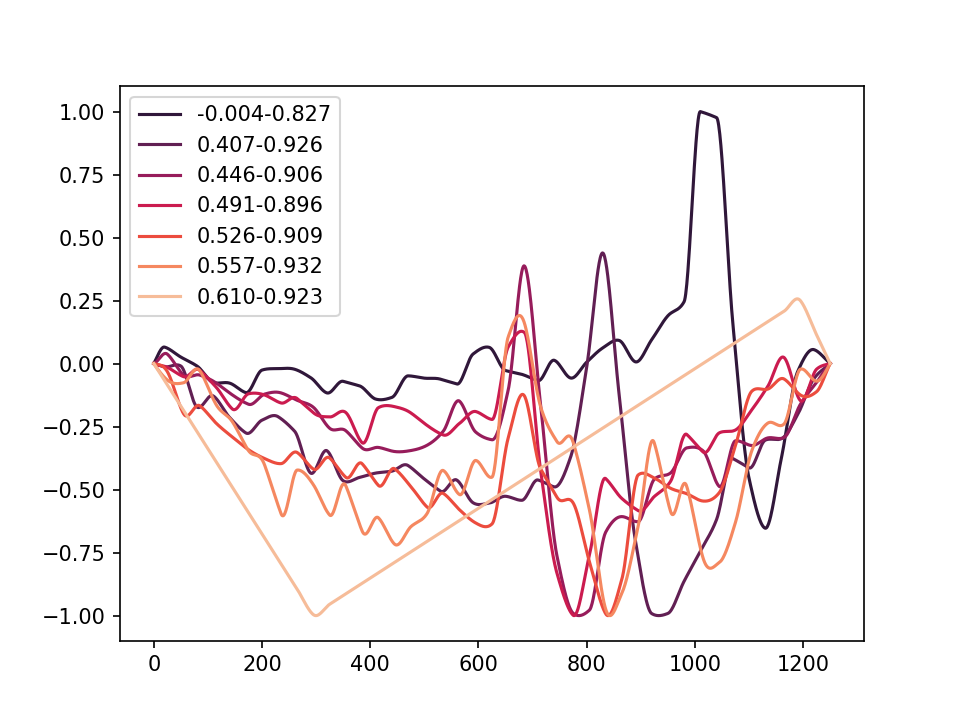

In [97]:
x_them = X_train
x_us = np.transpose(X_training, (0,2,1))
sorted_indexes = np.argsort(W[:,1])[::120]

cmap = sns.color_palette('rocket', n_colors=sorted_indexes.size)
plt.figure()
for ii, ind in enumerate(sorted_indexes):
    plt.plot(x_us[ind,0,:], c=cmap[ii], label=f'{W[ind,1]:.3f}-{W[ind,0]:.3f}')
plt.legend()

In [74]:
for ind in np.where(W[:,1]<0.45)[0]:
    print(f'{ind}: {W[ind,1]}')

0: 0.41343221068382263
19: 0.36152949929237366
21: 0.445089727640152
29: 0.41321060061454773
40: 0.28243494033813477
44: 0.31710708141326904
45: 0.37435486912727356
46: 0.4163343012332916
48: 0.41555464267730713
52: 0.4155714213848114
58: 0.41520243883132935
61: 0.41540849208831787
64: 0.4223453998565674
67: 0.43382003903388977
68: 0.415201336145401
69: 0.31936854124069214
70: 0.406595379114151
72: 0.41469064354896545
76: 0.32746782898902893
78: 0.21389436721801758
80: 0.426896333694458
81: 0.4337196946144104
85: 0.3179394006729126
87: 0.43268147110939026
88: 0.41586580872535706
90: 0.40982770919799805
101: 0.4228728413581848
105: 0.32403841614723206
107: -7.102400889635874e-09
108: 0.4234541952610016
113: 0.41468796133995056
114: 0.4162903428077698
120: 0.4147685170173645
126: -0.0035431217402219772
127: 0.44654610753059387
128: 0.4158656597137451
130: 0.4228578209877014
132: 0.4146882891654968
135: 0.3366367220878601
137: 0.31704312562942505
146: 0.4464341700077057
147: 0.41517314314

<IPython.core.display.Javascript object>


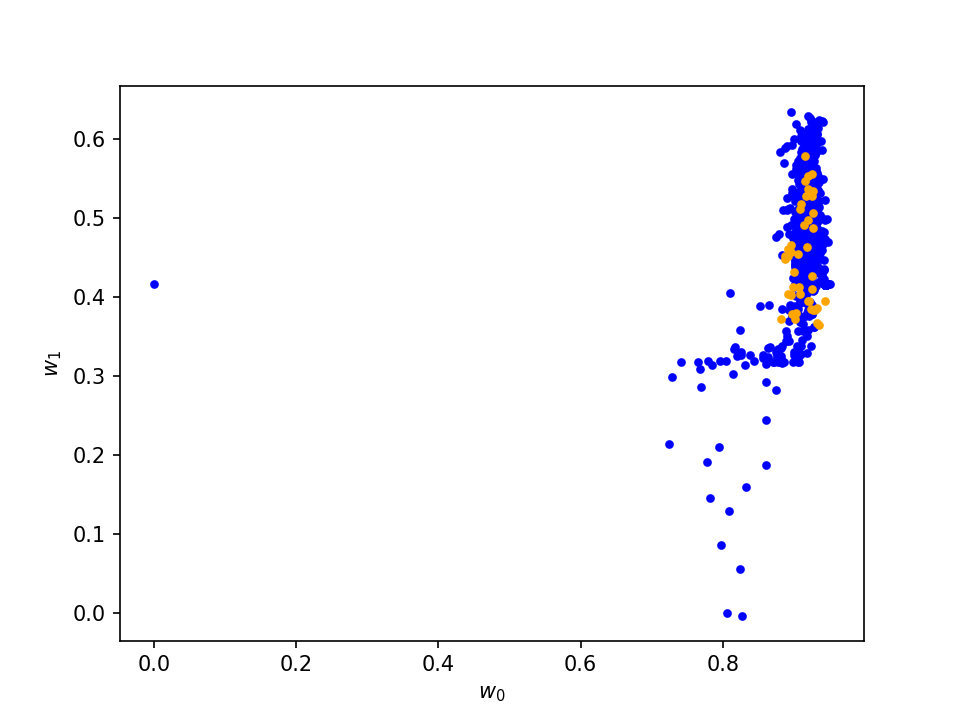

Text(0, 0.5, '$w_1$')

In [80]:
# Compute the embedding of the train data
W = fastmapsvm[0].transform(np.transpose(X_training, (0,2,1)))
W_test = fastmapsvm[0].transform(np.transpose(X_testing, (0,2,1)))
#W = fastmapsvm[0].transform(X_train)

plt.close('all')
fig, ax = plt.subplots()
ax.scatter(W[:, 0], W[:, 1], s=10, c='blue')
ax.scatter(W_test[:, 0], W_test[:, 1], s=10, c='orange')
#for label in range(2):
#    idxs = np.argwhere(y_train == label).flatten()
#    ax.scatter(W[idxs, 0], W[idxs, 1])
#ax.set_aspect(1)
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$')

In [37]:
W

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)